# **Conectar ao google drive**

In [3]:
# 1. Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importar bibliotecas**

In [ ]:
# Importar bibliotecas necessárias ao desenvolvimento do projeto
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# **Carregamento dos dados**

In [5]:
# Carregar os dados
file_path = '/content/drive/MyDrive/dhauz_desafio_ds/cancellation_prediction.csv'
df = pd.read_csv(file_path)
print(df.columns)

Index(['type', 'cancellation', 'days_between_booking_arrival',
       'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'country', 'market_segment', 'distribution_channel',
       'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
       'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
       'id_travel_agency_booking', 'id_person_booking', 'customer_type',
       'avg_price', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')


# **Questão 1a**:

> Elaborar hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis presentes no dataset





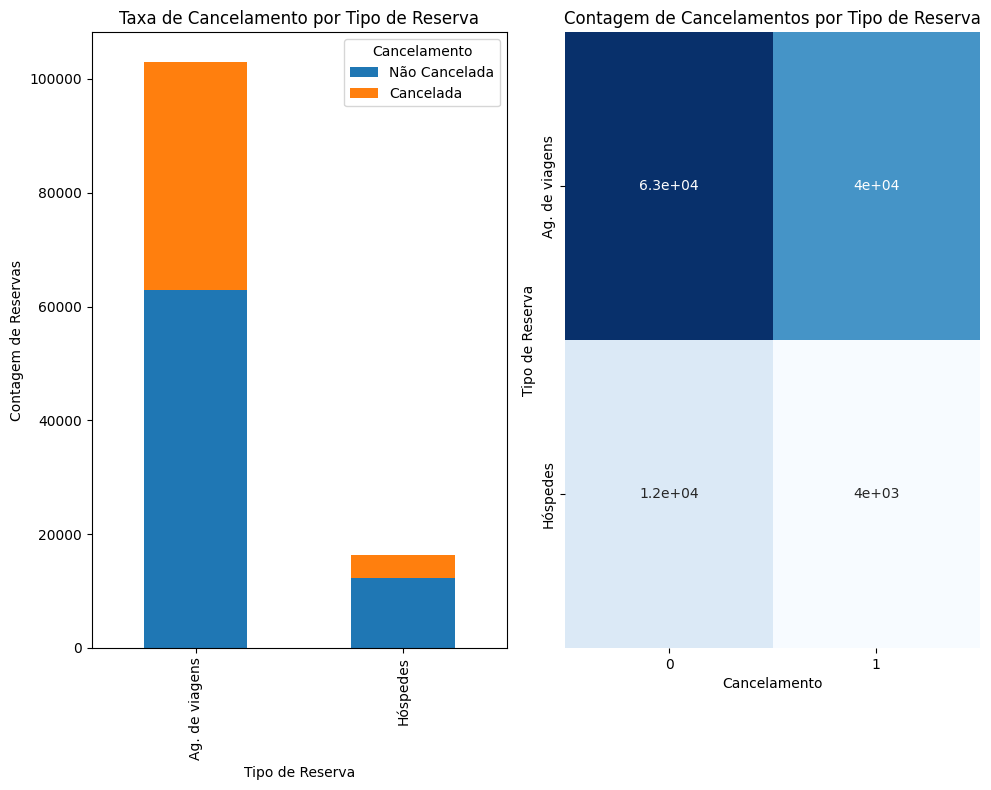

In [6]:
# Hipótese 1: Existem diferenças na taxa de cancelamento entre reservas feitas por agências de viagens e aquelas feitas diretamente pelos hóspedes - Variável: 'cancellation'

# Objetivo 1: Analisar se as reservas feitas por agências de viagens têm uma taxa de cancelamento diferente das reservas feitas diretamente pelos hóspedes, utilizando visualizações gráficas para investigar essa relação.

# Categorizar as reservas em "Agência de Viagens" ou "Hóspedes"
df['booking_type'] = df['id_travel_agency_booking'].apply(lambda x: 'Hóspedes' if pd.isna(x) else 'Ag. de viagens')

# Criar um gráfico de barras e um heatmap mostrando a taxa de cancelamento por tipo de reserva
plt.figure(figsize=(10, 8))
cancel_by_booking_type = df.groupby(['booking_type', 'cancellation']).size().unstack()
cancel_by_booking_type.plot(kind='bar', stacked=True, ax=plt.subplot(121))
plt.title('Taxa de Cancelamento por Tipo de Reserva')
plt.xlabel('Tipo de Reserva')
plt.ylabel('Contagem de Reservas')
plt.legend(title='Cancelamento', loc='upper right', labels=['Não Cancelada', 'Cancelada'])

plt.subplot(122)
sns.heatmap(cancel_by_booking_type, annot=True, cmap='Blues', cbar=False)
plt.title('Contagem de Cancelamentos por Tipo de Reserva')
plt.xlabel('Cancelamento')
plt.ylabel('Tipo de Reserva')

plt.tight_layout()
plt.show()


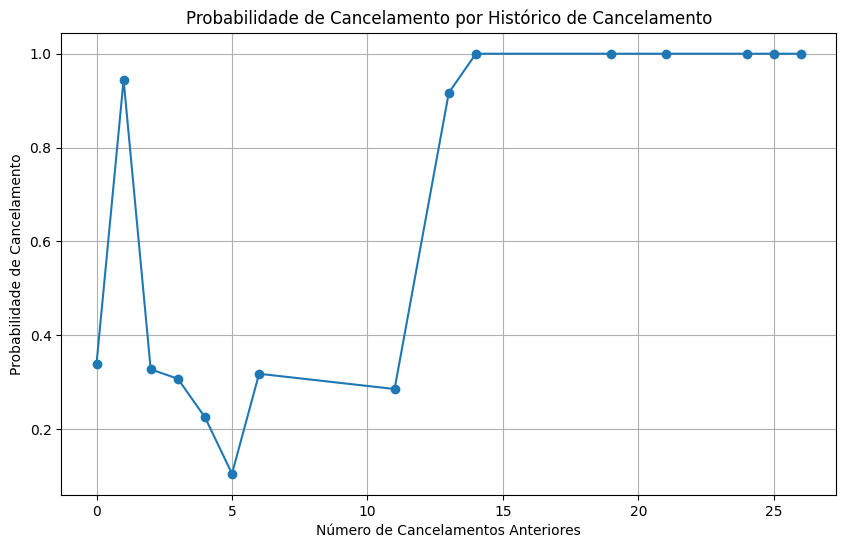

In [7]:
# Hipótese 2: Clientes que já cancelaram reservas no passado têm maior probabilidade de cancelar novamente - - Variável: 'cancellation'

# Calcular a taxa de cancelamento para cada número de cancelamentos anteriores

cancel_prob = df.groupby('num_previous_cancellations')['cancellation'].mean()

# Plotar o gráfico de linha
plt.figure(figsize=(10, 6))
cancel_prob.plot(marker='o')

# Adicionar título e rótulos dos eixos
plt.title('Probabilidade de Cancelamento por Histórico de Cancelamento')
plt.xlabel('Número de Cancelamentos Anteriores')
plt.ylabel('Probabilidade de Cancelamento')

# Adicionar grade
plt.grid(True)

# Exibir o gráfico
plt.show()

# Calcular a contagem de reservas e a taxa de cancelamento para cada número de cancelamentos anteriores
cancel_counts = df.groupby('num_previous_cancellations')['cancellation'].agg(['count', 'mean']).reset_index()

# Renomear as colunas
cancel_counts.columns = ['Num_Previous_Cancellations', 'Reserva_Count', 'Cancelamento_Taxa']

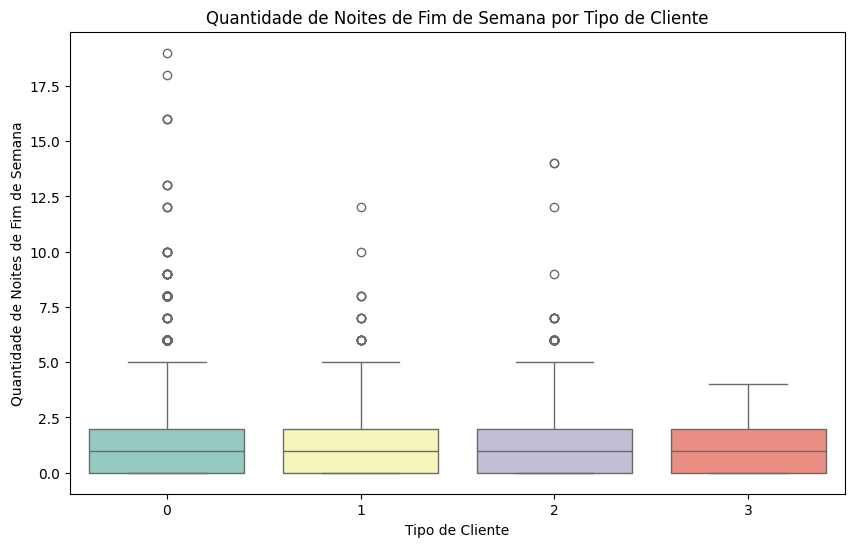

In [8]:
# Hipótese 3: O tipo de cliente influencia a quantidade de noites reservadas - Variável> 'customer_type'

# Objetivo 3: Analisar se diferentes tipos de clientes têm diferentes padrões na quantidade de noites reservadas

import seaborn as sns
import matplotlib.pyplot as plt

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='customer_type', y='num_weekend_nights', hue='customer_type', palette='Set3', legend=False)
plt.title('Quantidade de Noites de Fim de Semana por Tipo de Cliente')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Quantidade de Noites de Fim de Semana')

plt.show()

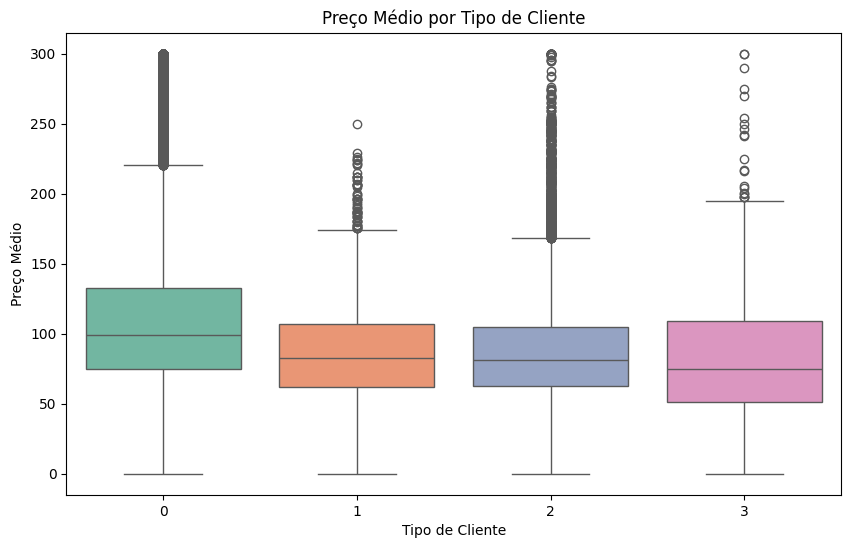

In [9]:
# Hipótese 4: Diferentes tipos de clientes têm diferentes padrões de gastos médios - Variável: 'customer_type'

# Objetivo 4: Comparar a distribuição dos preços médios das reservas para cada tipo de cliente, ajudando a identificar possíveis disparidades nos padrões de gastos entre eles.

import seaborn as sns
import matplotlib.pyplot as plt

# Desativar os avisos
import warnings
warnings.filterwarnings("ignore")

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='customer_type', y='avg_price', palette='Set2')
plt.title('Preço Médio por Tipo de Cliente')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Preço Médio')
plt.show()


# **Questão 1b:**

> Desenvolver um modelo preditivo de classificação para identificar cancelamentos e utilizar métricas adequadas para argumentar sobre a efetividade do modelo



In [10]:
# Modelo de classificação - Randon Forest

# Importar bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Limpeza e preparação dos dados
df['num_children'].fillna(0, inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['id_travel_agency_booking'].fillna(0, inplace=True)

# Remover 'cancellation' de X e atribuí-la a y
X = df.drop('cancellation', axis=1)
y = df['cancellation']

# Dividir os dados em conjunto de treinamento e teste (80% treinamento, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar as colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Criar o pré-processador para tratar variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Preencher os valores ausentes e codificar variáveis categóricas
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Inicializar e treinar o modelo RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_processed, y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = model_rf.predict(X_test_processed)

# Avaliar o desempenho do modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print("\nClassification Report for Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))




Random Forest Classifier Accuracy: 0.8956361504313594

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     14907
           1       0.90      0.81      0.85      8971

    accuracy                           0.90     23878
   macro avg       0.90      0.88      0.89     23878
weighted avg       0.90      0.90      0.89     23878



# **Questão 1c:**


> Realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?

In [11]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Definir os modelos que deseja comparar
model_random_forest = RandomForestClassifier(random_state=42)

# Definir pré-processador para transformar variáveis categóricas em numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Transformar os dados categóricos em numéricos
X_processed = preprocessor.fit_transform(X)

# Preencher os valores ausentes
imputer = SimpleImputer(strategy='mean')
X_processed = imputer.fit_transform(X_processed)

# Realizar validação cruzada com separação aleatória
cv_scores_random = cross_val_score(model_random_forest, X_processed, y, cv=5)

# Realizar validação cruzada com separação temporal
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_time_series = cross_val_score(model_random_forest, X_processed, y, cv=tscv)

# Comparar os resultados
print("\nCross-validation Scores (Random Split):", cv_scores_random)
print("Mean Accuracy (Random Split):", cv_scores_random.mean())

print("\nCross-validation Scores (Time Series Split):", cv_scores_time_series)
print("Mean Accuracy (Time Series Split):", cv_scores_time_series.mean())





Cross-validation Scores (Random Split): [0.66894212 0.59531787 0.49091214 0.4715219  0.51109808]
Mean Accuracy (Random Split): 0.5475584219783901

Cross-validation Scores (Time Series Split): [0.4637652  0.5813147  0.95627701 0.34058699 0.19157704]
Mean Accuracy (Time Series Split): 0.5067041913760177


# **Resposta Questão 1c:**

> Os resultados obtidos pela validação cruzada revelam diferenças significativas entre a separação temporal e aleatória. Enquanto a separação temporal alcançou uma precisão média de 50%, a aleatória obteve uma precisão média de 54%. A escolha do método mais adequado depende consideravelmente do contexto do problema em questão. Em cenários onde os dados possuem uma ordem temporal específica e a previsão de eventos futuros é uma métrica crucial, a separação temporal é a mais indicada. Por outro lado, a separação aleatória é preferível quando não há uma ordem temporal clara nos dados e o objetivo principal é criar um modelo generalista para predição de eventos futuros. No contexto da rede de hotéis em análise, visto que lidamos com dados de reservas, recomendo a utilização de modelos de séries temporais. Esses modelos permitem a análise de tendências e padrões que se modificam ao longo do tempo devido a fatores sazonais, tendências de mercado, entre outros.